In [ ]:
#7 트랜스포머 (357~387)


- 위치 인코딩
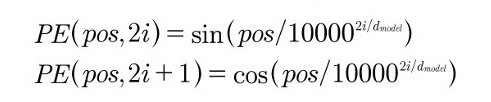

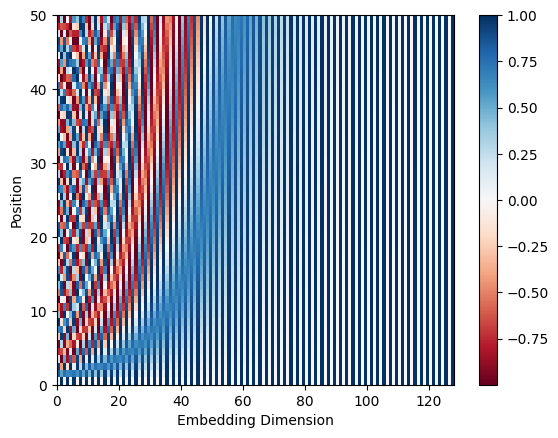

In [ ]:
#위치 인코딩

import math
import torch
from torch import nn
from matplotlib import pyplot as plt

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))

        pe = torch.zeros(max_len,1,d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe)

    def forward(self, x):
      x = x + self.pe[: x.size(0)]
      return self.dropout(x)

encoding = PositionalEncoding(d_model=128, max_len=50)

plt.pcolormesh(encoding.pe.numpy().squeeze(), cmap="RdBu")
plt.xlabel("Embedding Dimension")
plt.xlim((0,128))
plt.ylabel("Position")
plt.colorbar()
plt.show()

#모델 실습
- 영어-독일어 번역 모델 구성
- Multi30k 데이터셋

In [ ]:
pip install torchdata torchtext portalocker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 31.4 MB/s eta 0:00:00


In [ ]:
#데이터세트 다운로드 및 전처리

import torchtext

from torchtext.datasets import Multi30k
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

def generate_tokens(text_iter, language):
  language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}

  for text in text_iter: ##계속 오류,,,,,
    yield token_transform(text[language_index[language]])



SRC_LANGUAGE = "de"
TGT_LANGUAGE = "en"
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ["<unk>", "<pad>", "<bos>", "<eos>"]

token_transform = {
      SRC_LANGUAGE: get_tokenizer("spacy", language="de_core_news_sm"),
      TGT_LANGUAGE: get_tokenizer("spacy", language="en_core_web_sm")
}

print("Token Trasform")
print(token_transform)

vocab_transform = {}

for language in [SRC_LANGUAGE, TGT_LANGUAGE]:
    train_iter = Multi30k(split="train", language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    vocab_transform[language] = build_vocab_from_iterator(
        generate_tokens(train_iter, language),
        min_freq=1,
        specials=special_symbols,
        special_first=True
)

for language in [SRC_LANGUAGE, TGT_LANGUAGE]:
  vocab_transform[language].set_default_index(UNK_IDX)

print(vocab_transform)

/usr/local/lib/python3.12/dist-packages/torchtext/datasets/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.12/dist-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.12/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext i

Token Trasform
{'de': functools.partial(<function _spacy_tokenize at 0x78200d98fe20>, spacy=<spacy.lang.de.German object at 0x78200878f6b0>), 'en': functools.partial(<function _spacy_tokenize at 0x78200d98fe20>, spacy=<spacy.lang.en.English object at 0x782008fa3ce0>)}


TypeError: 'dict' object is not callable

In [ ]:
from torchtext.datasets import Multi30k
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

# 언어 설정 및 special symbols
SRC_LANGUAGE = "de"
TGT_LANGUAGE = "en"
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ["<unk>", "<pad>", "<bos>", "<eos>"]

# spaCy 기반 토크나이저
token_transform = {
    SRC_LANGUAGE: get_tokenizer("spacy", language="de_core_news_sm"),
    TGT_LANGUAGE: get_tokenizer("spacy", language="en_core_web_sm"),
}
print("Token Transform:")
print(token_transform)

# 토큰 생성 함수
def generate_tokens(text_iter, language):
    language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}
    for text in text_iter:  # text = (de, en)
        yield token_transform[language](text[language_index[language]])

# vocab 생성
vocab_transform = {}
for language in [SRC_LANGUAGE, TGT_LANGUAGE]:
    train_iter = Multi30k(split="train", language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    vocab_transform[language] = build_vocab_from_iterator(
        generate_tokens(train_iter, language),
        min_freq=1,
        specials=special_symbols,
        special_first=True,
    )

# UNK 인덱스 설정
for language in [SRC_LANGUAGE, TGT_LANGUAGE]:
    vocab_transform[language].set_default_index(UNK_IDX)

print("Vocab Transform:")
print(vocab_transform)

Token Transform:
{'de': functools.partial(<function _spacy_tokenize at 0x78200d98fe20>, spacy=<spacy.lang.de.German object at 0x781fe41924b0>), 'en': functools.partial(<function _spacy_tokenize at 0x78200d98fe20>, spacy=<spacy.lang.en.English object at 0x781fdfeac830>)}
Vocab Transform:
{'de': Vocab(), 'en': Vocab()}


In [ ]:
#트랜스포머 모델 구성

import math
import torch
from torch import nn

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))

        pe = torch.zeros(max_len,1,d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe)

    def forward(self, x):
      x = x + self.pe[: x.size(0)]
      return self.dropout(x)

class TokenEmbedding(nn.Module):
  def __init__(self, vocab_size, emb_size):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, emb_size)
    self.embed_size = emb_size

  def forward(self, tokens):
    return self.embedding(tokens.long()) * math.sqrt(self.embed_size)

#Seq2SeqTransformer 클래스 - TokenEmbedding 클래스로 소스 데이터와 입력 데이터를 입력 임베딩으로 변환하여 src_tok_emb 와 tgt_tok_emb 생성
class Seq2SeqTransformer(nn.Module):
  def __init__(
      self,
      num_encoder_layers,
      num_decoder_layers,
      emb_size,
      max_len,
      nhead,
      src_vocab_size,
      tgt_vocab_size,
      dim_feedforward=512,
      dropout=0.1,
  ):
    super().__init__()
    self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
    self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
    self.positional_encoding = PositionalEncoding(d_model=emb_size, max_len=max_len, dropout=dropout)

    self.transformer = nn.Transformer(
        d_model=emb_size,
        nhead=nhead,
        num_encoder_layers=num_encoder_layers,
        num_decoder_layers=num_decoder_layers,
        dim_feedforward=dim_feedforward,
        dropout=dropout,
    )
    self.generator = nn.Linear(emb_size, tgt_vocab_size)

  def forward(
      self,
      src,
      tgt,
      src_mask,
      tgt_mask,
      src_padding_mask,
      tgt_padding_mask,
      memory_key_padding_mask,
  ):
    src_emb = self.positional_encoding(self.src_tok_emb(src))
    tgt_emb = self.positional_encoding(self.tgt_tok_emb(tgt))
    outs = self.transformer(
        src = src_emb,
        tgt = tgt_emb,
        src_mask = src_mask,
        tgt_mask = tgt_mask,
        memory_mask = None,
        src_key_padding_mask = src_padding_mask,
        tgt_key_padding_mask = tgt_padding_mask,
        memory_key_padding_mask = memory_key_padding_mask,
    )
    return self.generator(outs)

  def encode(self, src, src_mask):
    return self.transformer.encoder(
        self.positional_encoding(self.src_tok_emb(src)), src_mask
    )

  def decode(self, tgt, memory, tgt_mask):
    return self.transformer.decoder(
        self.positional_encoding(self.tgt_tok_emb(tgt)), memory, tgt_mask)




Seq2SeqTranformer 클래스에서 소스와 타깃 데이터의 어휘 사전 크기를 입력 받아 트랜스포머 임베딩 크기로 변환

이 입력 임베딩에 Positional Encoding 을 적용해 트랜스포머 블록에 입력

In [ ]:
#트랜스포머 클래스

transformer = torch.nn.Transformer(
    d_model=512, #임베딩 차원 - 트랜스포머 모델의 입력/출력 차원 크기
    nhead=8, #멀티 헤드 어텐션의 헤드 수
    num_encoder_layers=6,
    num_decoder_layers=6,
    dim_feedforward=2048, #순방향 신경망의 은닉층 크기
    dropout=0.1,
    activation=torch.nn.functional.relu,
    layer_norm_eps=1e-05,
)


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
#트랜스포머 순방향 메서드

output = transformer.forward(
    src,
    tgt,
    src_mask=None,
    tgt_mask=None,
    memory_mask=None,
    src_key_padding_mask=None,
    tgt_key_padding_mask=None,
    memory_key_padding_mask=None,
)

NameError: name 'src' is not defined

In [ ]:
from logging import NullHandler
#트랜스포머 모델 구조

from torch import optim

BATCH_SIZE = 128
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

model = Seq2SeqTransformer(
    num_encoder_layers=3,
    num_decoder_layers=3,
    emb_size=512,
    max_len=512,
    nhead=8,
    src_vocab_size=len(vocab_transform[SRC_LANGUAGE]),
    tgt_vocab_size=len(vocab_transform[TGT_LANGUAGE]),
    dim_feedforward=512,
).to(DEVICE)

criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = optim.Adam(model.parameters())

for main_name, main_module in model.named_children():
  print(main_name)
  for sub_name, sub_module in main_module.named_children():
    print("L", sub_name)
    for ssub_name, ssub_module in sub_module.named_children():
      print("| L", ssub_name)
      for sssub_name, sssub_module in ssub_module.named_children():
        print("| | L", sssub_name)


src_tok_emb
L embedding
tgt_tok_emb
L embedding
positional_encoding
L dropout
transformer
L encoder
| L layers
| | L 0
| | L 1
| | L 2
| L norm
L decoder
| L layers
| | L 0
| | L 1
| | L 2
| L norm
generator


In [ ]:
#배치 데이터 생성

from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

def sequential_transforms(*transforms):
  def func(txt_input):
    for transform in transforms:
      txt_input = transform(txt_input)
    return txt_input
  return func

def input_transform(token_ids):
  return torch.cat(
      (torch.tensor([BOS_IDX]), torch.tensor(token_ids), torch.tensor([EOS_IDX]))
  )

def collator(batch):
  src_batch, tgt_batch = [], []
  for src_sample, tgt_sample in batch:
    src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
    tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

  src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
  tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
  return src_batch, tgt_batch

text_transform = {}

for language in [SRC_LANGUAGE, TGT_LANGUAGE]:
  text_transform[language] = sequential_transforms(
      token_transform[language],
      vocab_transform[language],
      input_transform
  )

data_iter = Multi30k(split="train", language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
dataloader = DataLoader(data_iter, batch_size=BATCH_SIZE, collate_fn=collator)
source_tensor, target_tensor = next(iter(dataloader))

print("(source, target):")
print(next(iter(data_iter)))

print("source_batch:", source_tensor.shape)
print(source_tensor)
print("target_batch:", target_tensor.shape)
print(target_tensor)


(source, target):
('Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.', 'Two young, White males are outside near many bushes.')
source_batch: torch.Size([27, 128])
tensor([[ 2,  2,  2,  ...,  2,  2,  2],
        [21, 84,  5,  ..., 21, 14, 14],
        [85, 31, 69,  ..., 46, 38, 17],
        ...,
        [ 1,  1,  1,  ...,  1,  1,  1],
        [ 1,  1,  1,  ...,  1,  1,  1],
        [ 1,  1,  1,  ...,  1,  1,  1]])
target_batch: torch.Size([24, 128])
tensor([[  2,   2,   2,  ...,   2,   2,   2],
        [ 19, 165,   6,  ...,  19,   6,   6],
        [ 25,  36,  61,  ...,  52,  39,  16],
        ...,
        [  1,   1,   1,  ...,   1,   1,   1],
        [  1,   1,   1,  ...,   1,   1,   1],
        [  1,   1,   1,  ...,   1,   1,   1]])


/usr/local/lib/python3.12/dist-packages/torch/utils/data/datapipes/iter/combining.py:337: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "


In [ ]:
#어텐션 마스크 생성

def generate_square_subsequent_mask(s):
  mask = (torch.triu(torch.ones((s, s), device=DEVICE)) == 1).transpose(0, 1)
  mask = (
      mask.float()
      .masked_fill(mask == 0, float("-inf"))
      .masked_fill(mask == 1, float(0.0))
  )
  return mask

def create_mask(src, tgt):
  src_seq_len = src.shape[0]
  tgt_seq_len = tgt.shape[0]

  tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
  src_mask = torch.zeros((src_seq_len, src_seq_len), device=DEVICE).type(torch.bool)

  src_padding_mask = (src==PAD_IDX).transpose(0,1)
  tgt_padding_mask = (tgt==PAD_IDX).transpose(0,1)

  return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

target_input = target_tensor[:-1, :]
torget_out = target_tensor[1:, :]

source_mask, target_mask, source_padding_mask, target_padding_mask = create_mask(
    source_tensor, target_input
)
print(source_mask.shape)
print(source_mask)
print(target_mask.shape)
print(target_mask)
print(source_padding_mask.shape)
print(source_padding_mask)
print(target_padding_mask.shape)
print(target_padding_mask)


torch.Size([27, 27])
tensor([[False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False, Fa

In [ ]:
#모델 학습 및 평가

def run(model, optimizer, criterion, split):
  model.train() if split == "train" else model.eval()
  data_iter = Multi30k(split=split, language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
  dataloader = DataLoader(data_iter, batch_size=BATCH_SIZE, collate_fn=collator)

  losses = 0

  for source_batch, target_batch in dataloader:
    source_batch = source_batch.to(DEVICE)
    target_batch = target_batch.to(DEVICE)

    target_input = target_batch[:-1, :]
    target_output = target_batch[1:, :]

    src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(
        source_batch, target_input
    )

    logits = model(
        src = source_batch,
        tgt = target_input,
        src_mask = src_mask,
        tgt_mask = tgt_mask,
        src_padding_mask = src_padding_mask,
        tgt_padding_mask = tgt_padding_mask,
        memory_key_padding_mask = src_padding_mask,
    )

    optimizer.zero_grad()

    loss = criterion(
        logits.reshape(-1, logits.shape[-1]),
        target_output.reshape(-1)
    )

    if split == "train":
      loss.backward()
      optimizer.step()
    losses += loss.item()

  return losses/len(list(dataloader))

for epoch in range(5):
  train_loss = run(model, optimizer, criterion, "train")
  valid_loss = run(model, optimizer, criterion, "valid")
  print(f"Epoch: {epoch+1}, Train Loss: {train_loss:.3f}, Valid Loss: {valid_loss:.3f}")


/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch: 1, Train Loss: 4.684, Valid Loss: 3.965


In [ ]:
def greedy_decode(model, source_tensor, source_mask, max_len, start_symbol):
  source_tensor = source_tensor.to(DEVICE)
  source_mask = source_mask.to(DEVICE)

  memeory = model.encode(source_tensor, source_mask)
  ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)

  for i in range(max_len-1):
    memory = memory.to(DEVICE)
    tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                .type(torch.bool)).to(DEVICE)

    out = model.decode(ys, memory, tgt_mask)
    out = out.transpose(0, 1)
    prob = model.generator(out[:, -1])
    _, next_word = torch.max(prob, dim=1)
    next_word = next_word.item()

    ys = torch.cat([ys, torch.ones(1, 1).type_as(source_tensor.data).fill_(next_word)], dim=0)
    if next_word == EOS_IDX:
      break
  return ys

def translate(model, source_text):
  model.eval()
  source_tensor = text_transform[SRC_LANGUAGE](source_text).view(-1, 1)
  num_tokens = source_tensor.shape[0]
  src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
  tgt_tokens = greedy_decode(model, source_tensor, src_mask, max_len=num_tokens+5, start_symbol=BOS_IDX).flatten()
  output = vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))[1:-1]
  return " ".join(output)

output_oov = translate(model, "Eine Gruppe von Menschen steht vor einem Iglu .")
output = translate(model, "Eine Gruppe von Menschen steht vor einem Gebaude .")
print(output_oov)
print(output)